<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/SocioenvironmentalGeometry/code/JaySPUR_ProjectPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concept Geometry analysis pipeline
For Jay's SPUR project: <br>
Authors: <b>Roberto Vargas; Jay Williamson </b><br>
Codebook created by: <b>Roberto Vargas </b><br>
<br>
<b>Pipeline includes:</b><br>
*   Data restructuring: Sorting accoring to word list
*   Regression predicting MiBi using: <i>Race; RaceProportion of Zipcode (@ birth; 10yo; and now); Gender; Income; Age; NewsBias</i>

<br>
<br>

In [1]:
#@title Install dependancies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from itertools import combinations
import math
import statsmodels as sm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import csv
from tqdm import tqdm
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import requests
import geopandas as gpd
!pip install census
!pip install us
from census import Census
from us import states
import os


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:00
  Created wheel for us: filename=us-3.1.1-py3-none-any.whl size=12545 sha256=171cf22e76c8d0ba6a3bd438b53dba26a57d2fd8fcef6c7dced71cca556c19e9
  Stored in directory: /root/.cache/pip/wheels/da/f9/64/9669135a7ce533faf78e3b32259c505f964f03b069be6844f8
Successfully built us


In [2]:
#@title Define utility functions
def scoreMIBI(MIBIdat):
  MIBIscored = []
  for p in range(MIBIdat.shape[0]):
    piMIBI = MIBIdat.loc[p]
    piMIBI[0] = (7-piMIBI[0])+1
    piMIBI[3] = (7-piMIBI[3])+1
    piMIBI[7] = (7-piMIBI[7])+1
    pMIBI = np.mean(piMIBI)

    MIBIscored.append(pMIBI)

  return MIBIscored

def weightedHeatmap(PairData, words, PlotHM):

    '''
    Restructure RT into matrix data structure

    '''

    Wmat = np.zeros((len(words),len(words)))
    t = 0
    z = 0

    for i in range(len(words)):
        for j in range(len(words)):

            if i == j:
                Wmat[i,j] = np.NaN

            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]
                t += 1


    if PlotHM == 1:
        plt.imshow(Wmat,  cmap='RdBu', vmin=-7, vmax=7)
        plt.colorbar()
        plt.xticks(range(len(words)), words, rotation='vertical')
        plt.yticks(range(len(words)), words)
        plt.show()

    return Wmat

def ccbi_randperm(ntimes, nperm):

    '''
      p = ccbi_randperm(nitems,nperm)
      Parameters: number of items, number of random permutations
      Output: a matrix with nperm rows;
      Each row is an index of permuted item positions.

      returns a matrix (n,nitems)
      each row is a random permutation of nitems (labelled 1:nitems)
      produces n such permutations
      the random seed is changed at every call

    '''

    p = np.zeros((nperm, ntimes))
    for i in range(nperm):
        p[i,:] = np.random.permutation(ntimes)

    return p


def splitHalf_Reliability(dat, perm):
    """
    Compute the reliability within a measure
    This analysis splits the data into 2 halfs and then averages the similarity structure
    This analysis is repeated

    """
    pSplit = ccbi_randperm(dat.shape[1], perm)

    rho = []
    for p in range(perm):
        # Split data
        if dat.shape[1] % 2 == 0:  # is even
            frstHalf = dat.iloc[:, pSplit[p, :(pSplit.shape[1]//2)]]
            scndHalf = dat.iloc[:, pSplit[p, (pSplit.shape[1]//2):]]

        elif dat.shape[1] % 2 == 1:  # is odd
            frstHalf = dat.iloc[:, pSplit[p, :int(np.floor(pSplit.shape[1]/2))]]
            scndHalf = dat.iloc[:, pSplit[p, int(np.ceil(pSplit.shape[1]/2)):]]
        # Avg dist of each half
        avgFrstHalf = frstHalf.mean(axis=1)
        avgScndHalf = scndHalf.mean(axis=1)

        # Correlate halves
        rhoI = np.corrcoef(avgFrstHalf, avgScndHalf)[0,1]

        rho.append(rhoI)

    rho = np.mean(rho)

    return rho



def regPairDiff(X, Y, perm):

    '''

    Predict pair differences among a X in Y
 	X is vector or matrix of variables used to predict Y
 	Y is a continuous vector
 	perm is the number of permutations used to compare against the observed beta
  Dimensions of X and Y should all align

    '''

    # Generate the permutations
    pComb = ccbi_randperm(X.shape[0],perm)

    # Generate constant
    con = np.ones(X.shape[0])
    con = con.reshape(con.shape[0], 1)

    # Estimate observed beta
    xModel = np.concatenate((con, X), axis=1)
    betaObs, _, _, _ = np.linalg.lstsq(xModel.astype('float'), Y, rcond=None)

    betaPerm = []

    for p in range(perm):
        pCombi = pComb.astype(int)
        yPerm = Y[pCombi[p,:]]
        bPerm, _, _, _ = np.linalg.lstsq(xModel.astype('float'), yPerm, rcond=None)
        betaPerm.append(bPerm)

    betaPerm = pd.DataFrame(betaPerm)

    pval =[]
    for b in range(len(betaObs)):
      if betaObs[b] > 0:
        nBbeyond =  len(np.where(np.array(betaPerm[b]) > betaObs[b])[0])
        pb = nBbeyond/perm
        pval.append(pb)
      elif betaObs[b] < 0:
        nBbeyond = len([x for x in np.array(betaPerm[b]) if x < betaObs[b]])
        pb = nBbeyond/perm
        pval.append(pb)

      else:
        raise ValueError('observed beta is exactly equal to 0')

    return betaObs, pval, betaPerm


In [41]:
#@title Clean up Dataframes mask out participants who didn't complete all parts of session
#Data path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/SocioenvironmentalGeometry/data/'

# Load Demographic PRaM data
datDemo = pd.read_csv (path + 'demographic.csv', header=1)
#datPRaM = pd.read_csv (path + 'df_taskPRaM.csv', header=0)
pairLab = pd.read_csv (path + 'PRaM_pairLabels.csv', header=None)
news = pd.read_csv (path + 'df_News_coded.csv', header=1)
MIBI = pd.read_csv(path + 'df_MIBI.csv', header=1)

#remove misc row and incomplete sessions
datDemo = datDemo.drop(labels=0, axis=0)
datDemo = datDemo.reset_index(drop=True)
datDemo['Question Key'] = [sub[: -2] for sub in datDemo['Question Key']]
#datPRaM = datPRaM.drop(['Participant Private ID'], axis=1)
#datPRaM = datPRaM.reset_index(drop=True)
news = news.drop(labels=0, axis=0)
news = news.reset_index(drop=True)
MIBI = MIBI.drop(labels=0, axis=0)
MIBI['Question Key'] = [sub[: -2] for sub in MIBI['Question Key']]
MIBI = MIBI.reset_index(drop=True)

#Identify participants who did not complete all measures
lst1 = datDemo['Question Key']
lst2 = news['Question Key']
exPart = list(set(lst1) - set(lst2))
mask = datDemo['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
datDemo = datDemo[~mask]
#datPRaM = datPRaM[~mask]

#reset index just in case
datDemo = datDemo.reset_index(drop=True)
#datPRaM = datPRaM.reset_index(drop=True)
news = news.reset_index(drop=True)

#Sort pairs accoring to prefered combination
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]


In [42]:
#Mask out datDemo and news by participants who completed the MIBI
lst1 = datDemo['Question Key']
lst2 = news['Question Key']
lstKey = MIBI['Question Key']

exPart = list(set(lst1) - set(lstKey))
mask = datDemo['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
datDemo = datDemo[~mask]

exPart = list(set(lst2) - set(lstKey))
mask = news['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
news = news[~mask]

#reset index just in case
datDemo = datDemo.reset_index(drop=True)
news = news.reset_index(drop=True)

In [43]:
#@title Subset participants by those who have complete data
#Isolate Race variable
raceCol = datDemo.columns.get_loc('raceEth_v2')
bIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('Black or African American')].index
wIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('White')].index
IDCol = raceCol = datDemo.columns.get_loc('Question Key')
bID = datDemo.iloc[bIndx,IDCol]
wID = datDemo.iloc[wIndx,IDCol]
ID = pd.concat([wID,bID])

#Subset MIBI by bIndx
lst1 = MIBI['Question Key']
lst2 = bID
exPart = list(set(lst1) - set(lst2))
mask = MIBI['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
MIBI = MIBI[~mask]
MIBI = MIBI.drop(labels='Question Key',axis=1)
MIBI = MIBI.reset_index(drop=True)
MIBI = scoreMIBI(MIBI)
MIBI = pd.Series(MIBI)

#Isolate Zip variable
zipBornCol = datDemo.columns.get_loc('zipborn')
bZipBorn = datDemo.iloc[bIndx,zipBornCol]

zip10yCol = datDemo.columns.get_loc('response-3')
bZip10y = datDemo.iloc[bIndx,zip10yCol]

zipNowCol= datDemo.columns.get_loc('zipnow')
bZipNow = datDemo.iloc[bIndx,zipNowCol]

# Isolate Age variable and subset sample by race
ageCol = datDemo.columns.get_loc('age')
bAge = datDemo.iloc[bIndx,ageCol]
Age = bAge.replace(1984, 38)

# Isolate Income variable and subset sample by race
incCol = datDemo.columns.get_loc('Income')
bIncome = datDemo.iloc[bIndx,incCol]
Income = pd.Series(bIncome)

# Isolate Gender variable and create concatonated vector
gendCol = datDemo.columns.get_loc('gender')
bGender = datDemo.iloc[bIndx,gendCol]
Gender = pd.Series(bGender)

#Homogenize Gender responses to F and M and remove genders with insufficient representation
remIndx = Gender.str.contains(pat = 'non', case=False) | Gender.str.contains(pat = 'Gen', case=False)
Gender.loc[remIndx]= 'R'
femIndx = Gender.str.contains(pat = 'f',case=False) | Gender.str.contains(pat = 'w',case=False)
Gender.loc[femIndx]= 'F'
maleIndx = Gender.str.contains(pat = 'an',case=False) | Gender.str.contains(pat = 'al',case=False)
Gender.loc[maleIndx]= 'M'

#Isolate News bias and subset sample by race
newsbiasCol = news.columns.get_loc('avgBias')
bNewsBias = news.iloc[bIndx,newsbiasCol]
NewsBias = pd.Series(bNewsBias)

#Remove underrepesented gender identities (i.e, non-bianary)
Gender_nG = Gender[~remIndx]
Income_nG = Income[~remIndx]
Age_nG = Age[~remIndx]
NewsBias_nG = NewsBias[~remIndx]
bZipBorn = bZipBorn[~remIndx]
bZip10y = bZip10y[~remIndx]
bZipNow = bZipNow[~remIndx]
bID = bID[~remIndx]
remIndx = remIndx.reset_index(drop=True)
MIBI = MIBI[~remIndx]

#Remove participants who only consumed algorithmic news sources
remIdxNBias= NewsBias.str.contains(pat = 'x', case=False)
Gender = Gender_nG[~remIdxNBias]
Income = Income_nG[~remIdxNBias]
Age = Age_nG[~remIdxNBias]
NewsBias = NewsBias_nG[~remIdxNBias]
NewsBias = NewsBias.astype('float')
bZipBorn = bZipBorn[~remIdxNBias]
bZip10y = bZip10y[~remIdxNBias]
bZipNow = bZipNow[~remIdxNBias]
bID = bID[~remIdxNBias] #used to make sure participants align
# remIdxNBias = remIdxNBias.reset_index(drop=True)
# MIBI = MIBI[~remIdxNBias]


In [44]:
pIndx = np.concatenate([wIndx,bIndx])

# Isolate Gender variable and create concatonated vector
gendCol = datDemo.columns.get_loc('gender')
pGender = datDemo.iloc[pIndx,gendCol]
Gender = pd.Series(pGender)

#Homogenize Gender responses to F and M and remove genders with insufficient representation
remIndx = Gender.str.contains(pat = 'non', case=False) | Gender.str.contains(pat = 'Gen', case=False)

#Isolate News bias and subset sample by race
newsbiasCol = news.columns.get_loc('avgBias')
pNewsBias = news.iloc[pIndx,newsbiasCol]
NewsBias = pd.Series(pNewsBias)
NewsBias_nG = NewsBias[~remIndx]

remIdxNBias= NewsBias.str.contains(pat = 'x', case=False)

zipNowCol= datDemo.columns.get_loc('zipnow')
ZipNow = datDemo.iloc[pIndx,zipNowCol]

ZipNow = ZipNow[~remIndx]
ID = ID[~remIndx]

ZipNow = ZipNow[~remIdxNBias]
ID_ng = ID[~remIdxNBias]




#Incorperate Census query code here
# bZipNow
ZipNow = ZipNow.reset_index(drop=True)
ZipNow = [round(sub) for sub in ZipNow]
# Set API key
c = Census("3467d4b27d132a110e0b5e096a94d6486208098d")
PropNow = []
for z in tqdm(range(len(bZipNow))):
  zip= ZipNow[z] #'15217'
  info = c.acs5.state_zipcode(('NAME', 'B02001_003E', 'B01003_001E'),states.WA.fips,zip,year=2021)
  if len(info) == 0:
    PropNow.append(-1)
  else :
    Propi = (info[0]['B02001_003E']/info[0]['B01003_001E'])*100
    PropNow.append(Propi)

#Find index of all participants with NA
PropNow = pd.Series(PropNow)
PropNow = PropNow.reset_index(drop=True)
remIndxZip = PropNow[PropNow == -1].index

100%|██████████| 213/213 [01:49<00:00,  1.95it/s]


In [48]:
len(np.unique(ZipNow))

421

In [ ]:
#Incorperate Census query code here
# bZipNow
bZipNow = bZipNow.reset_index(drop=True)
bZipNow = [round(sub) for sub in bZipNow]
# Set API key
c = Census("3467d4b27d132a110e0b5e096a94d6486208098d")
bPropNow = []
for z in tqdm(range(len(bZipNow))):
  zip= bZipNow[z] #'15217'
  info = c.acs5.state_zipcode(('NAME', 'B02001_003E', 'B01003_001E'),states.WA.fips,zip,year=2021)
  if len(info) == 0:
    bPropNow.append(-1)
  else :
    bPropi = (info[0]['B02001_003E']/info[0]['B01003_001E'])*100
    bPropNow.append(bPropi)

#Find index of all participants with NA
bPropNow = pd.Series(bPropNow)
bPropNow = bPropNow.reset_index(drop=True)
remIndxZip = bPropNow[bPropNow == -1].index

100%|██████████| 213/213 [01:56<00:00,  1.83it/s]


In [ ]:
#Subset all relevant variables by those who also have data for zipcodes
#Reset indexes as necessary
Age = Age.reset_index(drop=True)
Income = Income.reset_index(drop=True)
NewsBias = NewsBias.reset_index(drop=True)
MIBI = MIBI.reset_index(drop=True)
Gender = Gender.reset_index(drop=True)
bPropNow = bPropNow.reset_index(drop=True)

Age = Age.drop(remIndxZip)
Income = Income.drop(remIndxZip)
NewsBias = NewsBias.drop(remIndxZip)
MIBI = MIBI.drop(remIndxZip)
Gender = Gender.drop(remIndxZip)
bPropNow = bPropNow.drop(remIndxZip)

#Reset indexes as necessary
Age = Age.reset_index(drop=True)
Income = Income.reset_index(drop=True)
NewsBias = NewsBias.reset_index(drop=True)
MIBI = MIBI.reset_index(drop=True)
Gender = Gender.reset_index(drop=True)
bPropNow = bPropNow.reset_index(drop=True)

print(f'Sample of participant completing session = ', len(datDemo['Question Key']))
print(f'Of',len(datDemo['Question Key']), ',' ,(len(bIndx)+len(wIndx)), 'participants identified as non-Hispanic White(', len(wIndx),') or Black/AfricanAmerican(', len(bIndx),')')
print(f'For the purposes of this study only the sample of', len(bIndx), 'Black/AfricanAmerican participants will be analyzed.')
print(f'of', (len(bIndx)), ',', len(Gender_nG), 'participants identified as Female(', sum(femIndx==1), ') or Male(', sum(maleIndx==1),')')
print(f'of the', len(Gender_nG), ',', len(remIndxZip), 'participants consumed a non-algorithmic news source with measurable political bias.')
print(f'of the', len(remIndxZip), ',', len(bZipNow), 'participants census info could be queries from zipcodes.')
print(f'The final analyzed sample contains', len(bPropNow), 'participants!')

Sample of participant completing session =  584
Of 584 , 571 participants identified as non-Hispanic White( 293 ) or Black/AfricanAmerican( 278 )
For the purposes of this study only the sample of 278 Black/AfricanAmerican participants will be analyzed.
of 278 , 276 participants identified as Female( 140 ) or Male( 136 )
of the 276 , 20 participants consumed a non-algorithmic news source with measurable political bias.
of the 20 , 213 participants census info could be queries from zipcodes.
The final analyzed sample contains 193 participants!


Mean age for sample: 38.11 ( SD = 11.41 )


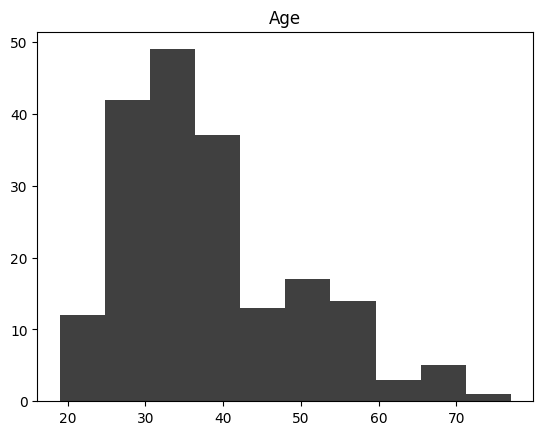

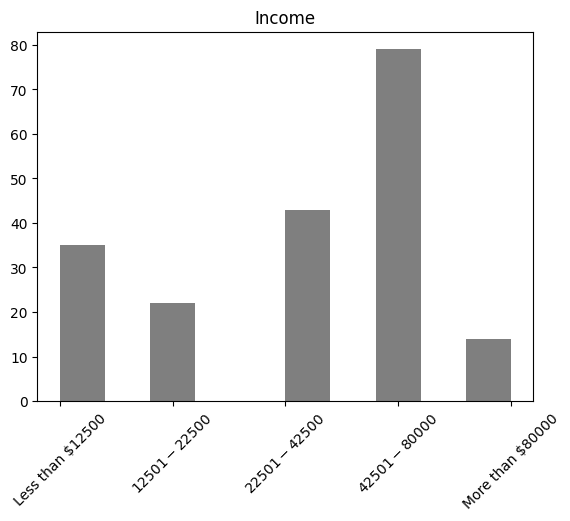

Mean News consumption bias for sample: 2.01 ( SD = 1.09 )


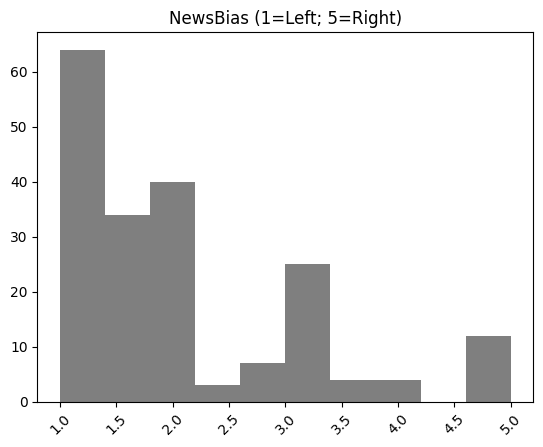

Mean MIBI for sample: 5.09 ( SD = 1.45 )


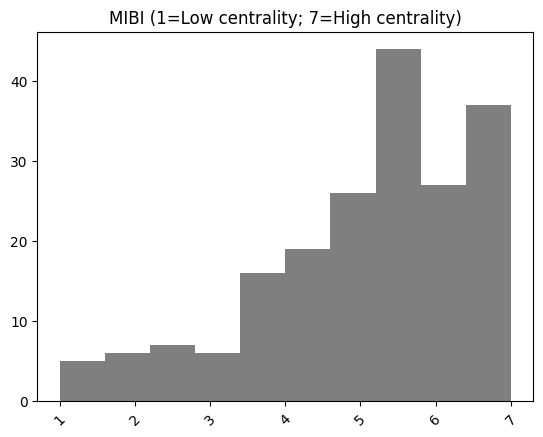

Mean Proportion Black in Zip for sample: 31.72 ( SD = 27.62 )


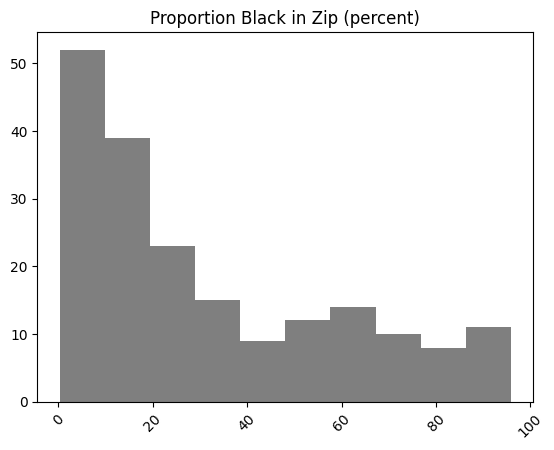

In [ ]:
#@title Plot descriptive statistics
#Participant descriptive statistics
# Plot age histograms
Age_mean = np.mean(Age)
Age_sd = np.std(Age)
print(f'Mean age for sample:', round(Age_mean,2), '( SD =', round(Age_sd,2), ')')
plt.hist(Age, alpha=0.75, color= 'k')
plt.title('Age')
plt.show()

# Plot Income histograms
customSort = {'Less than $12500':0, '$12501-$22500':1, '$22501-$42500':2, '$42501-$80000':3 ,'More than $80000':4}
IncPlot = Income.sort_values(key=lambda x: x.map(customSort))
plt.hist(IncPlot,
         alpha=0.5,
         color='k')
plt.title('Income')
plt.xticks(rotation = 45)
plt.show()

# Plot NewsBias histograms
Newsbias_mean = np.mean(NewsBias)
Newsbias_sd = np.std(NewsBias)

print(f'Mean News consumption bias for sample:', round(Newsbias_mean,2), '( SD =', round(Newsbias_sd,2), ')')
plt.hist(NewsBias.sort_values(axis=0),
         alpha=0.5,
         color='k')
plt.title('NewsBias (1=Left; 5=Right)')
plt.xticks(rotation = 45)
plt.show()

# Plot MIBI histograms
MIBI_mean = np.mean(MIBI)
MIBI_sd = np.std(MIBI)

print(f'Mean MIBI for sample:', round(MIBI_mean,2), '( SD =', round(MIBI_sd,2), ')')
plt.hist(MIBI.sort_values(axis=0),
         alpha=0.5,
         color='k')
plt.title('MIBI (1=Low centrality; 7=High centrality)')
plt.xticks(rotation = 45)
plt.show()

# Plot PropCommunity histograms
bPropNow_mean = np.mean(bPropNow)
bPropNow_sd = np.std(bPropNow)

print(f'Mean Proportion Black in Zip for sample:', round(bPropNow_mean,2), '( SD =', round(bPropNow_sd,2), ')')
plt.hist(bPropNow.sort_values(axis=0),
         alpha=0.5,
         color='k')
plt.title('Proportion Black in Zip (percent)')
plt.xticks(rotation = 45)
plt.show()


In [ ]:
#Format Gender and Income into something that can be used in the model
#Gender [Female = 1; Male = 0]
FInd = Gender.str.contains('F')
MInd = Gender.str.contains('M')
RInd = Gender.str.contains('R')
Gender.loc[FInd] = 1
Gender.loc[MInd] = 0
femaleCode = Gender

#SES [Higher value means higher income bracket]
i0Ind = Income.str.contains(pat = 'Less than $12500', case=False, regex=False)
i1Ind = Income.str.contains(pat = '$12501-$22500', case=False, regex=False)
i2Ind = Income.str.contains(pat = '$22501-$42500', case=False, regex=False)
i3Ind = Income.str.contains(pat = '$42501-$80000', case=False, regex=False)
i4Ind = Income.str.contains(pat = 'More than $80000', case=False, regex=False)
Income.loc[i0Ind] = 0
Income.loc[i1Ind] = 1
Income.loc[i2Ind] = 2
Income.loc[i3Ind] = 3
Income.loc[i4Ind] = 4

#Reset index for series (just in case)
Age = Age.to_numpy() #convert series to array
Income = Income.to_numpy()  #convert series to array
NewsBias = NewsBias.to_numpy()  #convert series to array
femaleCode = femaleCode.to_numpy() #convert series to array
bPropNow = bPropNow.to_numpy() #convert series to array
#MIBI = MIBI.to_numpy() #convert series to array

#Reshape for concatenation
Age =  Age.reshape(Age.shape[0],1)
Income =  Income.reshape(Income.shape[0],1)
NewsBias = NewsBias.reshape(NewsBias.shape[0],1)
femaleCode =  femaleCode.reshape(femaleCode.shape[0],1)
bPropNow = bPropNow.reshape(bPropNow.shape[0],1)
#MIBI =  MIBI.reshape(MIBI.shape[0],1)

In [ ]:
#Execute model
# X = Gender(femaleCode); Income; Age; NewsBias; bPropNow
# Y = MIBI

#Concatonate
X = np.concatenate((femaleCode, Income, Age, NewsBias, bPropNow), axis=1)

#Y: Pair data
Y = MIBI

bObsPairsPRaM = []
pPairsPRaM = []
perm = 1000

betaObs, pval, betaPerm1 = regPairDiff(X, Y, perm)

In [ ]:
betaObs

array([ 4.70569877e+00,  5.15074187e-01,  1.69470632e-01,  1.12310013e-02,
       -3.52933914e-01,  1.86102417e-03])

In [ ]:
pval

[0.815, 0.004, 0.038, 0.115, 0.0, 0.331]

In [ ]:
#Export data to CSV files
# FDR_sig.to_csv('FDRsig.csv')
# pPairsPRaM.to_csv('pValPairs.csv')
# bObsPairsPRaM.to_csv('bObsPairsPRaM.csv')
# PRaM_cat.to_csv('PRaM_finalModel.csv')